#### Initial imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Set processing parameters

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
USE_PARALLEL = False

### Prep lists of input files

In [3]:
from glob import glob
import re
import pandas as pd
from random import sample, seed

In [7]:
encoder_list = ['resnet34']
avail_suffix = ['rgb', 'tpi', 'ndvi']

In [8]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set directories for training data and labels
DATA_FOLDER = './cnn_train_images_2cm/{}_{}.tif'
LABEL_FOLDER = './cnn_train_labels_2cm/{}_labels.tif'

# set parameters for each resolution
res_dict = {
    5: {'min_factor': 3,
        'max_factor': 6},
    10: {'min_factor': 1,
        'max_factor': 4},
    15: {'min_factor': 1,
        'max_factor': 3},
    30: {'min_factor': 1,
        'max_factor': 2}
}

In [9]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [10]:
# get all ids to be used
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[2:]) for y in all_ids]))

In [11]:
# separate training and test data and get paths to files
all_files = glob(DATA_FOLDER.replace('{}', '*'))
all_train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(all_train_tiles))

all_train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in all_train_tiles]
test_ids = list(set(all_ids) - set(all_train_ids))

seed(321)
valid_ids = sample(all_train_ids, int(np.ceil(len(all_train_ids)*0.3)))
train_ids = list(set(all_train_ids) - set(valid_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
valid_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in valid_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

In [12]:
tile_ids = df_tiles[(df_tiles['trainer'] != 'Nick') &
                    (df_tiles['Digitize'] == 1)].apply(lambda x: '_'.join([x.Pasture, x.Tile]), axis=1)
#all_tiles#
[x for x in all_tiles if x not in tile_ids.to_list()]

[]

In [13]:
[x for x in tile_ids.to_list() if x not in all_tiles]

[]

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io
from skimage.transform import resize

In [15]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_s[np.isnan(image_s)] = 0
            if s == 'ndvi':
                image_s[image_s < 0] = 0
            if self.preprocessing:
                image_s = normalize_fn(image_s, s, image_stats)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='float32')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # convert final image arrays to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1).astype('float32'))
        mask = torch.from_numpy(mask.transpose(2, 0, 1).astype('float32'))
        return image, mask
        
    def __len__(self):
        return len(self.ids)


### Augmentations

In [16]:
import albumentations as albu
import random

In [17]:
def get_training_augmentation(min_factor, max_factor):
    win_size = 32 * random.randint(min_factor, max_factor)
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomCrop(height=win_size, width=win_size, always_apply=True),

        #albu.GaussNoise(p=0.2, var_limit=1.0),
        #albu.Perspective(p=0.5),

        #albu.OneOf(
        #    [
        #        #albu.CLAHE(p=1), # required int8 images
        #        albu.RandomBrightnessContrast(p=1),
        #        #albu.RandomGamma(p=1),
        #        #albu.HueSaturationValue(p=1),
        #    ],
        #    p=0.9,
        #),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=(3, 7), p=1),
                albu.MotionBlur(blur_limit=(3, 7), p=1),
            ],
            p=0.25,
        ),
    ]
    return albu.Compose(train_transform)

### Create preprocessing function from training data stats

In [18]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import torch.nn as nn
import gc

In [19]:
mod_list = ['deeplabplus']
inputs_list = [['rgb', 'tpi', 'ndvi'], 
               ['rgb', 'tpi'],
               ['rgb', 'ndvi'],
               ['tpi'], 
               ['rgb'],
              ]

In [20]:
CLASSES = ['burrow']
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cuda'# 'cpu'# 
VALID_THRESH = 0.01
CYCLE_EPOCHS = 6 # must be an even number as currently coded. Should be between 4 and 16
BATCH_SIZE = 11
MIN_CYCLES = 2
MAX_EPOCHS = 60 # should be evenly divided by CYCLE_EPOCHS
CYCLE_PATIENCE = 2
#PATIENCE = 5

In [21]:
print(DEVICE)

cuda:0


In [22]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)

### Check that augmentation and normalization are working as expected

In [23]:
res = 5

In [24]:
# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [25]:
print(image_stats)

{'rgb': {'min': 0.0, 'max': 255.0}, 'tpi': {'min': -0.1, 'max': 0.4}, 'ndvi': {'min': 0.0, 'max': 1.0}}


torch.Size([3, 128, 128])


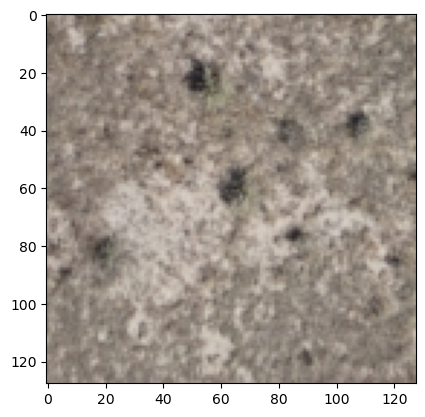

In [26]:
suffix_list = ['rgb']
train_dataset = Dataset(
        train_ids,
        suffix_list,
        re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
        re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
        augmentation=get_training_augmentation(res_dict[res]['min_factor'],
                                               res_dict[res]['max_factor']),
        preprocessing=True,
        classes=CLASSES)
i = 21
img = train_dataset[i]
print(img[0].shape)
try:
    plt.imshow(img[0].cpu().numpy().squeeze())
except TypeError:
    plt.imshow(img[0].cpu().numpy().transpose(1, 2, 0))

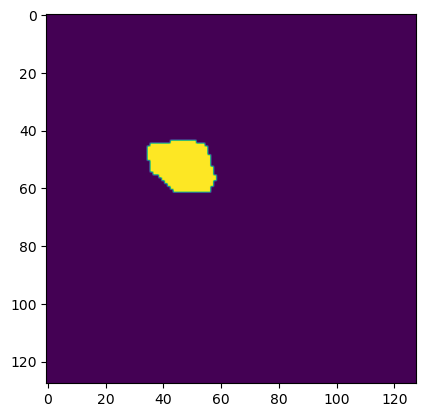

In [27]:
plt.imshow(img[1].cpu().numpy().squeeze())

In [30]:
lr_list = np.sort([0.1**i for i in range(1, 6)] + [0.25**i for i in range(1, 6)] + [0.5**i for i in range(1, 6)] + [0.75])
lr_list = list(dict.fromkeys(lr_list))
lr_list

[1.0000000000000003e-05,
 0.00010000000000000002,
 0.0009765625,
 0.0010000000000000002,
 0.00390625,
 0.010000000000000002,
 0.015625,
 0.03125,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 0.75]

In [31]:
test_lr = True
if test_lr:
    df_out = pd.DataFrame(columns=['model', 'LR', 'F-score'])
    idx_i = 0
    for res in res_dict:
        #res = 5
        print('\n\n----------------------------------------------------------')
        print('Running learning rate tests for RESOLUTION = ' + str(res) + ' cm')

        ### Create and train model

        for mod in ['deeplabplus']:
            print('\n\n----------------------------------------------------------')
            print('----------------------------------------------------------')
            print('Now running model: ' + mod)
            print('----------------------------------------------------------')
            for suffix_sub in [['rgb', 'tpi', 'ndvi']]:
                suffix_list = list(suffix_sub)
                print('\n\n----------------------------------------------------------')
                print(suffix_list)
                train_dataset = Dataset(
                    train_ids,
                    suffix_list,
                    re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                    re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                    augmentation=get_training_augmentation(res_dict[res]['min_factor'],
                                                           res_dict[res]['max_factor']),
                    preprocessing=True,
                    classes=CLASSES)

                train_loader = DataLoader(train_dataset, batch_size=11, shuffle=True,
                                          drop_last=True, num_workers=8, pin_memory=False)

                for lr_i in lr_list:
                    # create segmentation model with pretrained encoder
                    if mod == 'deeplabplus':
                        model = smp.DeepLabV3Plus(
                            encoder_name=ENCODER, 
                            encoder_weights=ENCODER_WEIGHTS, 
                            classes=len(CLASSES), 
                            activation=ACTIVATION,
                            in_channels=train_dataset[0][0].shape[0],
                        )
                    elif mod == 'fpn':
                        model = smp.FPN(
                            encoder_name=ENCODER, 
                            encoder_weights=ENCODER_WEIGHTS, 
                            classes=len(CLASSES), 
                            activation=ACTIVATION,
                            in_channels=train_dataset[0][0].shape[0],
                        )
                    elif mod == 'manet':
                        model = smp.MAnet(
                            encoder_name=ENCODER, 
                            encoder_weights=ENCODER_WEIGHTS, 
                            classes=len(CLASSES), 
                            activation=ACTIVATION,
                            in_channels=train_dataset[0][0].shape[0],
                        )
                    elif mod == 'unetplus':
                        model = smp.UnetPlusPlus(
                            encoder_name=ENCODER, 
                            encoder_weights=ENCODER_WEIGHTS, 
                            classes=len(CLASSES), 
                            activation=ACTIVATION,
                            in_channels=train_dataset[0][0].shape[0],
                        )
                    else:
                        print('ERROR: model "' + mod + '" not found!')
                        break

                    if USE_PARALLEL:
                        model = nn.DataParallel(model)

                    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

                    # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
                    # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

                    loss = smp.losses.MCCLoss()
                    loss.__name__ = 'mccloss'
                    metrics = [
                        utils.metrics.IoU(threshold=0.5),
                        utils.metrics.Accuracy(threshold=0.5),
                        utils.metrics.Precision(threshold=0.5),
                        utils.metrics.Recall(threshold=0.5),
                        utils.metrics.Fscore(threshold=0.5)
                    ]

                    optimizer = torch.optim.SGD([ 
                        dict(params=model.parameters(), lr=lr_i, momentum=0.8),
                    ])

                    # create epoch runners 
                    # it is a simple loop of iterating over dataloader`s samples
                    train_epoch = utils.train.TrainEpoch(
                        model, 
                        loss=loss, 
                        metrics=metrics, 
                        optimizer=optimizer,
                        device=DEVICE,
                        verbose=True,
                    )

                    # train model for 5 epochs

                    max_score = 0
                    max_score_train = 0
                    no_improve = 0

                    print('-----------------------')
                    print('LR = ' + str(lr_i))
                    for i in range(1, CYCLE_EPOCHS + 1):
                        print('\nEpoch: {}'.format(i))
                        train_logs = train_epoch.run(train_loader)
                        train_logs['fscore_old'] = train_logs['fscore']
                        beta = 1.0
                        train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])
                    df_tmp = pd.DataFrame({
                        'model': mod,
                        'LR': lr_i,
                        'F-score': train_logs['fscore'],
                        'resolution': res,
                        'inputs': '_'.join(suffix_sub),
                    }, index=[idx_i])
                    df_out = pd.concat([df_out, df_tmp])
                    idx_i += 1


                    del model, train_epoch
                    gc.collect()
                    torch.cuda.empty_cache()
                df_out.to_csv('./_utils/lr_step_testing_downscaled.csv', index=False)



----------------------------------------------------------
Running learning rate tests for RESOLUTION = 5 cm


----------------------------------------------------------
----------------------------------------------------------
Now running model: deeplabplus
----------------------------------------------------------


----------------------------------------------------------
['rgb', 'tpi', 'ndvi']
-----------------------
LR = 1.0000000000000003e-05

Epoch: 1
train: 100%|█| 28/28 [00:05<00:00,  5.01it/s, mccloss - 0.9943, iou_score - 0.01013, accuracy - 0.4115, precision - 0.01019, recall - 0.6

Epoch: 2
train: 100%|█| 28/28 [00:02<00:00, 10.63it/s, mccloss - 0.9951, iou_score - 0.009939, accuracy - 0.4135, precision - 0.009999, recall - 0

Epoch: 3
train: 100%|█| 28/28 [00:02<00:00, 10.56it/s, mccloss - 0.9927, iou_score - 0.01102, accuracy - 0.4146, precision - 0.01107, recall - 0.7

Epoch: 4
train: 100%|█| 28/28 [00:02<00:00, 10.68it/s, mccloss - 0.9947, iou_score - 0.01021, accu

In [32]:
df_out = pd.read_csv('./_utils/lr_step_testing_downscaled.csv')
import seaborn as sns

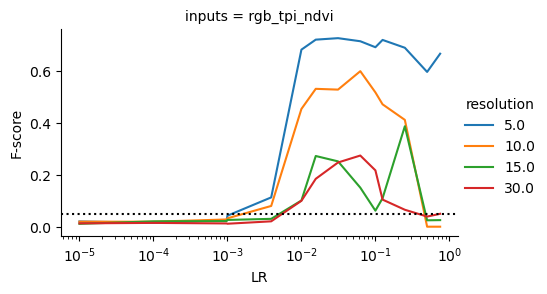

In [36]:
g = sns.FacetGrid(hue='resolution', col='inputs', data=df_out, height=3, aspect=1.6, legend_out=True)
g.map_dataframe(sns.lineplot, x='LR', y='F-score')
#g.set_xlim((0.0001, 0.02))
g.set(xscale="log")
g.add_legend()
plt.axhline(y=0.05, linestyle='dotted', c='black')
plt.show()

In [35]:
#df_out
df_out.loc[df_out['F-score'] >= 0.05].groupby('resolution').first()

,model,LR,F-score,inputs
resolution,,,,
5.0,deeplabplus,0.003906,0.112712,rgb_tpi_ndvi
10.0,deeplabplus,0.003906,0.079787,rgb_tpi_ndvi
15.0,deeplabplus,0.010000,0.100741,rgb_tpi_ndvi
30.0,deeplabplus,0.010000,0.099570,rgb_tpi_ndvi


In [39]:
df_out.loc[df_out['F-score'] > 0.05].drop_duplicates(['resolution', 'LR']).set_index('resolution')

,model,LR,F-score,inputs
resolution,,,,
5.0,deeplabplus,0.003906,0.112712,rgb_tpi_ndvi
5.0,deeplabplus,0.010000,0.681028,rgb_tpi_ndvi
5.0,deeplabplus,0.015625,0.719511,rgb_tpi_ndvi
5.0,deeplabplus,0.031250,0.725234,rgb_tpi_ndvi
5.0,deeplabplus,0.062500,0.713368,rgb_tpi_ndvi
5.0,deeplabplus,0.100000,0.690357,rgb_tpi_ndvi
5.0,deeplabplus,0.125000,0.718431,rgb_tpi_ndvi
5.0,deeplabplus,0.250000,0.688336,rgb_tpi_ndvi
5.0,deeplabplus,0.500000,0.595333,rgb_tpi_ndvi


In [81]:
8.0e-02

0.08

In [40]:
res_dict_lr = {
    5: {'min_lr': 4.0e-03,
        'max_lr': 6.0e-02},
    10: {'min_lr': 4.0e-03,
         'max_lr': 3.0e-02},
    15: {'min_lr': 1.0e-02,
         'max_lr': 4.0e-02},
    30: {'min_lr': 1.0e-02,
         'max_lr': 1.0e-01}
}

In [ ]:
for res in res_dict:
#res = 5
    print('\n\n----------------------------------------------------------')
    print('Running all models for RESOLUTION = ' + str(res) + ' cm')

    ### Create and train model

    for mod in mod_list:
        print('----------------------------------------------------------')
        print('Now running model: ' + mod)
        print('----------------------------------------------------------')
        outDIR = './cnn_results_' + mod + '_' + str(res) + 'cm/'
        if not os.path.exists(outDIR):
            os.mkdir(outDIR)
        for suffix_list in inputs_list:
            print('----------------------------------------------------------')
            print(suffix_list)
            if os.path.exists(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt'):
                print('skipping - already trained.')
                continue
            else:
                train_dataset = Dataset(
                    train_ids,
                    suffix_list,
                    re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                    re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                    augmentation=get_training_augmentation(res_dict[res]['min_factor'],
                                                           res_dict[res]['max_factor']),
                    preprocessing=True,
                    classes=CLASSES)

                valid_dataset = Dataset(
                    valid_ids,
                    suffix_list,
                    re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                    re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                    preprocessing=True,
                    classes=CLASSES)


                train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                      drop_last=True, num_workers=8, pin_memory=False)
                valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=False)

                # create segmentation model with pretrained encoder
                if mod == 'deeplabplus':
                    model = smp.DeepLabV3Plus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'fpn':
                    model = smp.FPN(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'manet':
                    model = smp.MAnet(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'unetplus':
                    model = smp.UnetPlusPlus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                else:
                    print('ERROR: model "' + mod + '" not found!')
                    break

                if USE_PARALLEL:
                    model = nn.DataParallel(model)

                preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

                # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
                # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

                loss = smp.losses.MCCLoss()
                loss.__name__ = 'mccloss'
                metrics = [
                    utils.metrics.IoU(threshold=0.5),
                    utils.metrics.Accuracy(threshold=0.5),
                    utils.metrics.Precision(threshold=0.5),
                    utils.metrics.Recall(threshold=0.5),
                    utils.metrics.Fscore(threshold=0.5)
                ]

                #optimizer = torch.optim.Adam([ 
            #    dict(params=model.parameters(), lr=0.0001),
            #])
            
            optimizer = torch.optim.SGD([ 
                dict(params=model.parameters(), lr=res_dict_lr[res]['max_lr']),
            ])
            
            #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=10e-3, 
            #                                                steps_per_epoch=len(train_loader), epochs=MAX_EPOCHS,
            #                                                three_phase=True,
            #                                                verbose=False)
            
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=res_dict_lr[res]['min_lr'], max_lr=res_dict_lr[res]['max_lr'],
                                                          step_size_up=len(train_dataset) * (CYCLE_EPOCHS/2) / BATCH_SIZE,
                                                          mode='triangular2')

            # create epoch runners 
            # it is a simple loop of iterating over dataloader`s samples
            train_epoch = utils.train.TrainEpoch(
                model, 
                loss=loss, 
                metrics=metrics, 
                optimizer=optimizer,
                oclr_scheduler=scheduler,
                device=DEVICE,
                verbose=True,
            )

            valid_epoch = utils.train.ValidEpoch(
                model, 
                loss=loss, 
                metrics=metrics, 
                device=DEVICE,
                verbose=True,
            )

            # train model for up to 60 epochs

            max_score = 0
            max_score_train = 0
            no_improve = 0
            for i in range(1, MAX_EPOCHS+1):
                print('\nEpoch: {}'.format(i))
                print('Learning rate: ' + str(optimizer.param_groups[0]['lr']))
                train_logs = train_epoch.run(train_loader)
                valid_logs = valid_epoch.run(valid_loader)
                valid_logs['fscore_old'] = valid_logs['fscore']
                beta = 1.0
                valid_logs['fscore'] = ((1 + beta) * valid_logs['recall'] * valid_logs['precision']) / (valid_logs['recall'] + beta * valid_logs['precision'])
                train_logs['fscore_old'] = train_logs['fscore']
                beta = 1.0
                train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])
                
                if i%CYCLE_EPOCHS == 0:
                    if (valid_logs['fscore'] - max_score) > VALID_THRESH:
                        max_score = valid_logs['fscore']
                        max_score_train = train_logs['fscore']
                        torch.save(model, outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm.pth')
                        valid_logs['best_epoch'] = i
                        valid_logs['resolution'] = float(res)
                        best_valid_logs = valid_logs.copy()
                        print('Model saved!')
                        no_improve = 0
                    else:
                        no_improve += 1
                        print('No improvement in ' + str(no_improve) + ' cycles. Model not saved.')

                    if i > (MIN_CYCLES * CYCLE_EPOCHS):
                        if no_improve >= CYCLE_PATIENCE:
                            if (train_logs['fscore'] - max_score_train) < 0.1:
                                print('More than ' + str(CYCLE_PATIENCE) + ' cycles without validation improvement while training improvement < 0.1...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                            elif no_improve == CYCLE_PATIENCE * 2:
                                print(str(CYCLE_PATIENCE * 2) + ' cycles without validation improvement...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                
                if i == MAX_EPOCHS:
                    print('maximum number of epochs reached...ending training')
                    with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))

                """for i in range(1, 61):

                    print('\nEpoch: {}'.format(i))
                    train_logs = train_epoch.run(train_loader)
                    valid_logs = valid_epoch.run(valid_loader)
                    valid_logs['fscore_old'] = valid_logs['fscore']
                    beta = 1.0
                    valid_logs['fscore'] = ((1 + beta) * valid_logs['recall'] * valid_logs['precision']) / (valid_logs['recall'] + beta * valid_logs['precision'])
                    train_logs['fscore_old'] = train_logs['fscore']
                    beta = 1.0
                    train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])                # do something (save model, change lr, etc.)
                
                    # do something (save model, change lr, etc.)
                    if max_score < valid_logs['fscore']:
                        max_score = valid_logs['fscore']
                        max_score_train = train_logs['fscore']
                        torch.save(model, outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm.pth')
                        valid_logs['best_epoch'] = i
                        valid_logs['resolution'] = float(res)
                        best_valid_logs = valid_logs.copy()
                        print('Model saved!')
                        no_improve = 0
                    else:
                        no_improve += 1
                        print('No improvement in ' + str(no_improve) + ' epochs. Model not saved.')

                    if i > 15:
                        if no_improve >= 5:
                            if (train_logs['fscore'] - max_score_train) < 0.05:
                                print('More than 5 epochs without validation improvement while learning rate <= 1e-5 and training improvement < 0.05...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                            elif (train_logs['fscore'] - max_score_train) < 0.15 and no_improve == 15:
                                print('15 epochs without validation improvement while learning rate <= 1e-5...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                    if i == 60:
                        with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))

                    if i%15 == 0:
                        no_improve = 0
                        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
                        print('Decrease decoder learning rate by factor of 10')"""

            del model, train_epoch, valid_epoch
            gc.collect()
            torch.cuda.empty_cache()



----------------------------------------------------------
Running all models for RESOLUTION = 5 cm
----------------------------------------------------------
Now running model: deeplabplus
----------------------------------------------------------
----------------------------------------------------------
['rgb', 'tpi', 'ndvi']

Epoch: 1
Learning rate: 0.004
train: 100%|█| 28/28 [00:02<00:00, 10.73it/s, mccloss - 0.9643, iou_score - 0.0143, accuracy - 0.2755, precision - 0.01431, recall - 0.93
valid: 100%|█| 133/133 [00:01<00:00, 68.37it/s, mccloss - 0.9853, iou_score - 0.009941, accuracy - 0.426, precision - 0.01009, recall - 0

Epoch: 2
Learning rate: 0.022666666666666672
train: 100%|█| 28/28 [00:02<00:00, 10.05it/s, mccloss - 0.7737, iou_score - 0.1747, accuracy - 0.8845, precision - 0.2213, recall - 0.762
valid: 100%|█| 133/133 [00:01<00:00, 67.45it/s, mccloss - 0.8451, iou_score - 0.2545, accuracy - 0.9772, precision - 0.2926, recall - 0.8

Epoch: 3
Learning rate: 0.04133333333

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train: 100%|█| 28/28 [00:03<00:00,  8.21it/s, mccloss - 0.4738, iou_score - 0.3729, accuracy - 0.9945, precision - 0.6136, recall - 0.518
valid: 100%|█| 133/133 [00:03<00:00, 43.33it/s, mccloss - 0.9649, iou_score - 0.54, accuracy - 0.9949, precision - 1.0, recall - 0.54, fs

Epoch: 6
Learning rate: 0.01999999999999999
train: 100%|█| 28/28 [00:02<00:00, 11.20it/s, mccloss - 0.4493, iou_score - 0.4029, accuracy - 0.9951, precision - 0.6103, recall - 0.535
valid: 100%|█| 133/133 [00:02<00:00, 58.65it/s, mccloss - 0.8069, iou_score - 0.5512, accuracy - 0.996, precision - 0.7696, recall - 0.71
Model saved!

Epoch: 7
Learning rate: 0.01
train: 100%|█| 28/28 [00:02<00:00, 11.38it/s, mccloss - 0.3756, iou_score - 0.4696, accuracy - 0.9957, precision - 0.6895, recall - 0.606
valid: 100%|█| 133/133 [00:02<00:00, 58.11it/s, mccloss - 0.8149, iou_score - 0.6057, accuracy - 0.9963, precision - 0.8902, recall - 0.6

Epoch: 8
Learning rate: 0.01500000000000001
train: 100%|█| 28/28 [00:02<00:00,  9.4

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



valid: 100%|█| 133/133 [00:02<00:00, 55.19it/s, mccloss - 0.8422, iou_score - 0.2419, accuracy - 0.9896, precision - 0.4161, recall - 0.6

Epoch: 11
Learning rate: 0.01999999999999999
train: 100%|█| 28/28 [00:02<00:00, 13.57it/s, mccloss - 0.4656, iou_score - 0.3827, accuracy - 0.9945, precision - 0.5711, recall - 0.585
valid: 100%|█| 133/133 [00:02<00:00, 62.75it/s, mccloss - 0.8244, iou_score - 0.6184, accuracy - 0.9962, precision - 0.9523, recall - 0.6

Epoch: 12
Learning rate: 0.01500000000000001
train: 100%|█| 28/28 [00:02<00:00, 12.82it/s, mccloss - 0.3922, iou_score - 0.4504, accuracy - 0.9947, precision - 0.65, recall - 0.6018,
valid: 100%|█| 133/133 [00:02<00:00, 61.60it/s, mccloss - 0.8096, iou_score - 0.5457, accuracy - 0.9959, precision - 0.7757, recall - 0.6
Model saved!

Epoch: 13
Learning rate: 0.01
train: 100%|█| 28/28 [00:02<00:00, 12.12it/s, mccloss - 0.3699, iou_score - 0.4635, accuracy - 0.9953, precision - 0.6774, recall - 0.624
valid: 100%|█| 133/133 [00:02<00:00,

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train: 100%|█| 28/28 [00:01<00:00, 15.50it/s, mccloss - 0.8215, iou_score - 0.1013, accuracy - 0.9795, precision - 0.1655, recall - 0.293
valid: 100%|█| 133/133 [00:02<00:00, 63.61it/s, mccloss - 0.9376, iou_score - 0.02882, accuracy - 0.8627, precision - 0.02975, recall - 0

Epoch: 9
Learning rate: 0.03999999999999998
train: 100%|█| 28/28 [00:01<00:00, 14.14it/s, mccloss - 0.8482, iou_score - 0.08325, accuracy - 0.9788, precision - 0.105, recall - 0.294
valid: 100%|█| 133/133 [00:02<00:00, 58.13it/s, mccloss - 0.9064, iou_score - 0.2656, accuracy - 0.9917, precision - 0.471, recall - 0.57

Epoch: 10
Learning rate: 0.05500000000000001
train: 100%|█| 28/28 [00:02<00:00, 12.44it/s, mccloss - 0.8404, iou_score - 0.09986, accuracy - 0.9906, precision - 0.2559, recall - 0.21
valid: 100%|█| 133/133 [00:02<00:00, 58.44it/s, mccloss - 0.9096, iou_score - 0.2261, accuracy - 0.9901, precision - 0.3752, recall - 0.5

Epoch: 11
Learning rate: 0.03999999999999998
train: 100%|█| 28/28 [00:01<00:00, 

In [ ]:
print('All processing complete!')